In [1]:
# importing Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
G = nx.read_gexf("Files/artists_graph_with_stats.gexf")
print(f"Reloaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Show attributes of a sample node
example_node = list(G.nodes())[0]
print("Example node attributes:", G.nodes[example_node])

Reloaded graph: 484 nodes, 7328 edges
Example node attributes: {'word_count': 4504, 'degree': 17, 'in_degree': 7, 'out_degree': 10, 'pagerank': 0.0006904376855434414, 'betweenness': 0.0008262812266717574, 'label': '10 Years (band)'}


In [3]:
# Quick stats
print("Average degree:", G.number_of_edges() / G.number_of_nodes())

# Top 10 artists by out-degree (who they reference)
out_degrees = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)
print("Top 10 by out-degree:", out_degrees[:10])

# Top 10 artists by in-degree (who is referenced most)
in_degrees = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)
print("Top 10 by in-degree:", in_degrees[:10])

Average degree: 15.140495867768594
Top 10 by out-degree: [('Alice in Chains', 74), ('Deep Purple', 71), ('Black Sabbath', 60), ('Def Leppard', 52), ('Bryan Adams', 51), ("Guns N' Roses", 51), ('Metallica', 47), ('Rush (band)', 47), ('Queen (band)', 45), ('The Smashing Pumpkins', 44)]
Top 10 by in-degree: [('Led Zeppelin', 119), ('Bob Dylan', 95), ('Queen (band)', 88), ('Metallica', 85), ('David Bowie', 83), ('Jimi Hendrix', 77), ('Black Sabbath', 74), ('Nirvana (band)', 74), ('U2', 73), ('Kiss (band)', 72)]


The Wikipedia rock performer network contains 488 nodes and 7,328 directed edges, giving an average degree of about 15. This means that, on average, each artist’s page links to 15 other performers in the network. Looking at out-degree (how many other performers a page references), bands like Alice in Chains (74), Deep Purple (71), and Black Sabbath (60) emerge as highly outward-looking nodes, pointing to many others. In contrast, in-degree (how many performers reference them) highlights the historically central figures: Led Zeppelin (119), Bob Dylan (95), Queen (88), and Metallica (85). These results make sense because such iconic acts are widely cited across Wikipedia pages, confirming their hub-like status in the rock ecosystem.

# Process Documentation

### Step-by-step procedure

The process of crawling the Wikipedia rock performer network involved several distinct stages. First, the list of mainstream rock performers was obtained from the dedicated Wikipedia page. Using regular expressions, all internal Wikipedia links corresponding to performers were extracted. These raw links were then cleaned by removing duplicates and filtering out irrelevant categories, templates, and non-performer links.

Next, each performer’s Wikipedia page was retrieved using the MediaWiki API. To ensure consistency, the pages were saved locally as plain text files in a structured directory, with one file per performer. A filename normalization function was applied to handle problematic characters such as slashes, spaces, or special symbols, ensuring that all files could be saved and later accessed without errors.

Once all the performer pages were collected, a second round of regular expression parsing was applied to each file to extract outgoing links. These links were cross-checked against the cleaned list of performer names to ensure that only relevant connections between rock performers were retained. The resulting connections were stored in a directed NetworkX graph, where nodes represent performers and edges represent references from one performer’s page to another.

Additional node attributes were then introduced. Specifically, the word count of each Wikipedia page was calculated and stored as a feature for the corresponding node. This allowed the network to capture not only relational information but also content size. Isolated nodes—performers with no incoming or outgoing links—were subsequently identified and removed to ensure the network contained only meaningful connections. Finally, the largest weakly connected component was extracted to provide a robust structure for subsequent statistical analysis and visualization.

### Most difficult part

The most challenging aspect of the process was handling inconsistencies in performer names and file saving. Wikipedia page titles often contain special characters (e.g., “AC/DC”), spaces, or disambiguation tags (e.g., “(band)”), which complicated both file naming and link matching. Without normalization, many files could not be accessed later, leading to incomplete results. Another challenge was filtering out non-performer links that persisted in the text despite cleaning efforts. Ensuring that only valid performer-to-performer edges were included required multiple rounds of debugging and refinement.

Another source of complexity was managing structural issues in the graph itself. The presence of isolated nodes required careful verification to confirm that they were not artifacts of missing data but genuinely disconnected performers. Furthermore, extracting the largest weakly connected component involved confirming that no relevant substructures were excluded from analysis. These steps added extra layers of decision-making and validation to the workflow.

### Use of LLM

Large Language Models were used as a support tool to speed up repetitive or technical tasks such as drafting regular expressions, suggesting file-normalization functions, and structuring the network-building code. LLMs also assisted in planning the sequence of operations, such as when to add word count attributes, remove isolated nodes, and extract the largest component.

All outputs were cross-checked against actual Wikipedia text and verified through manual testing to ensure correctness. This approach allowed the automation of boilerplate tasks while maintaining full control over the interpretation of results. In practice, the LLM reduced development time but final decisions on filtering, graph cleaning, and component extraction were based on manual verification.

### Reflection and improvements

If the process were repeated, three improvements would be prioritized. First, more robust data validation could be added, for example by cross-referencing extracted performer names with official Wikipedia categories (e.g., “Category:Rock_music_groups”) to avoid including non-performer pages. Second, instead of saving plain-text files, a lightweight database or structured JSON format could be used to store both raw page content and metadata, simplifying queries and updates. Third, automated handling of redirects and missing files would reduce manual intervention, especially for problematic pages with special characters.

In addition, the inclusion of word count as a node attribute could be expanded into richer textual metrics such as sentiment or topic analysis. Removing isolated nodes and working only with the largest connected component was a practical choice, but future work could investigate whether smaller disconnected subgraphs contain interesting stylistic or regional clusters. These refinements would improve reproducibility, minimize manual cleanup, and expand the analytical potential of the network.

# Summary Statistics

Number of nodes and links: 

In [4]:
# Basic stats
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes in the network: {num_nodes}")
print(f"Number of links in the network: {num_edges}")

Number of nodes in the network: 484
Number of links in the network: 7328


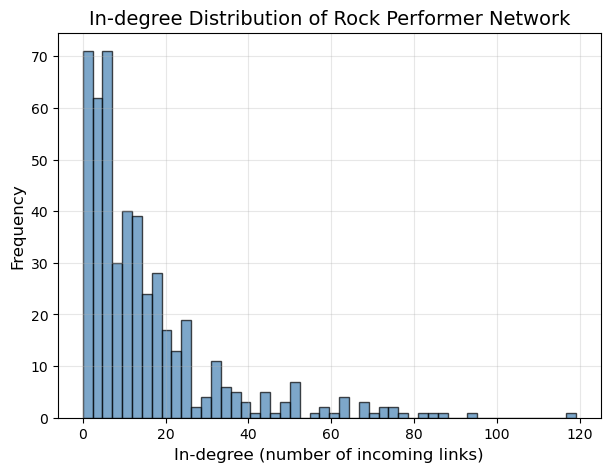

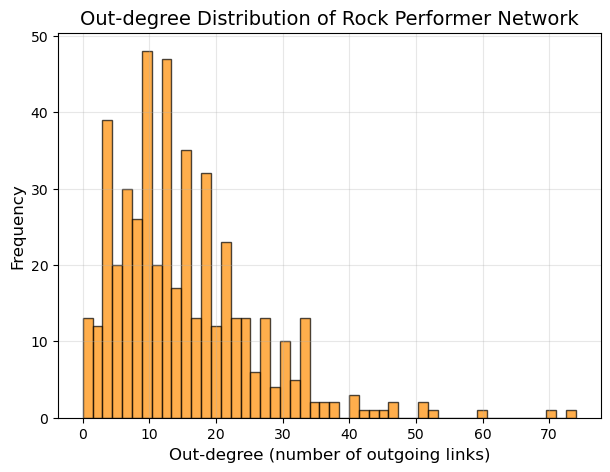

In [5]:
# Compute degree sequences
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

# Plot histogram of in-degree
plt.figure(figsize=(7,5))
plt.hist(in_degrees, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.title("In-degree Distribution of Rock Performer Network", fontsize=14)
plt.xlabel("In-degree (number of incoming links)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plot histogram of out-degree
plt.figure(figsize=(7,5))
plt.hist(out_degrees, bins=50, color="darkorange", edgecolor="black", alpha=0.7)
plt.title("Out-degree Distribution of Rock Performer Network", fontsize=14)
plt.xlabel("Out-degree (number of outgoing links)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

The in-degree distribution of the rock performer network exhibits a highly right-skewed structure, with most performers receiving only a small number of incoming links while a few iconic performers, such as Led Zeppelin and Bob Dylan, accumulate a disproportionately large number of references. This heavy-tailed pattern is characteristic of preferential attachment mechanisms often found in real-world information networks, where well-known or historically influential performers are cited more frequently across Wikipedia pages.

By contrast, the out-degree distribution is less skewed and more broadly distributed, with a relatively higher frequency of nodes exhibiting medium out-degrees. This indicates that many performer pages contain a moderate number of outgoing references to peers, reflecting the tendency of editors to include related acts, influences, and collaborations. Unlike the in-degree case, the out-degree is primarily determined by editorial effort and page length rather than performer popularity, explaining the smoother distribution.

The observed asymmetry between the two distributions highlights the distinction between structural popularity (in-degree, shaped by collective attention) and editorial detail (out-degree, shaped by page content). Together, these findings suggest that the performer network combines both social dynamics—where prominence amplifies visibility—and editorial dynamics, where the effort to contextualize a performer drives the number of outgoing references.

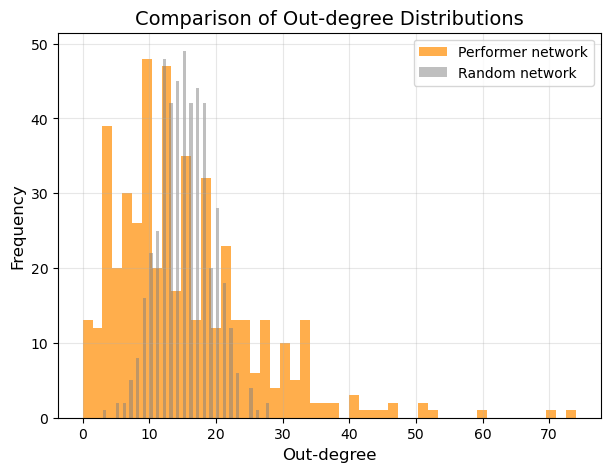

In [6]:
# Generate random network with same N, M
random_graph = nx.gnm_random_graph(num_nodes, num_edges, directed=True)
random_out_degrees = [d for n, d in random_graph.out_degree()]

plt.figure(figsize=(7,5))
plt.hist(out_degrees, bins=50, alpha=0.7, label="Performer network", color="darkorange")
plt.hist(random_out_degrees, bins=50, alpha=0.5, label="Random network", color="gray")
plt.title("Comparison of Out-degree Distributions", fontsize=14)
plt.xlabel("Out-degree", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Figure compares the out-degree distribution of the rock performer network with that of a random Erdős–Rényi network of equal size and density. The random network shows a bell-shaped distribution centered around the mean out-degree, consistent with the binomial (or approximately Poisson) degree distribution expected for such graphs. This indicates that most nodes in the random case have similar numbers of outgoing links, with very few nodes deviating strongly from the mean.

In contrast, the performer network displays a much broader and more heterogeneous distribution. While many nodes exhibit out-degrees around the average, a significant fraction of nodes deviate substantially, including performers with very low or exceptionally high out-degrees. This divergence reflects the editorial and cultural dynamics of Wikipedia: some performer pages are extensively detailed with numerous references to related acts, while others contain minimal cross-linking.

The key difference is that the performer network exhibits structural variability and heterogeneity absent in the random baseline. This suggests that the performer network cannot be explained by purely random linking mechanisms; instead, it reflects socially and historically contingent connections among artists, as well as the uneven efforts of Wikipedia editors.

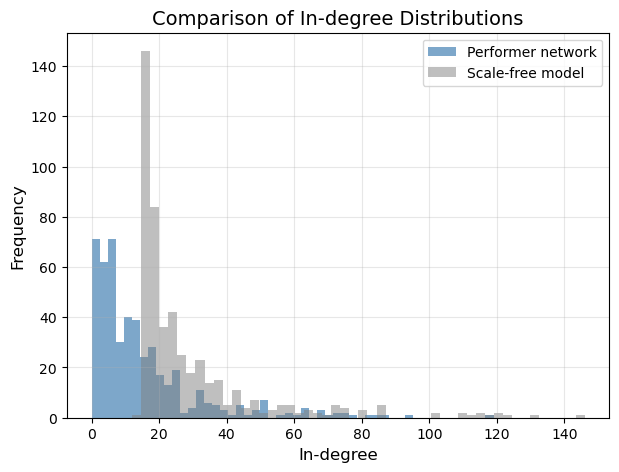

In [7]:
# Barabási-Albert scale-free model (approximation for in-degree distribution)
scale_free = nx.barabasi_albert_graph(num_nodes, int(num_edges/num_nodes))
scale_free_in_degrees = [d for n, d in scale_free.degree()]

plt.figure(figsize=(7,5))
plt.hist(in_degrees, bins=50, alpha=0.7, label="Performer network", color="steelblue")
plt.hist(scale_free_in_degrees, bins=50, alpha=0.5, label="Scale-free model", color="gray")
plt.title("Comparison of In-degree Distributions", fontsize=14)
plt.xlabel("In-degree", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Figure presents a comparison between the in-degree distribution of the rock performer network and that of a scale-free model generated with equivalent network size and density. The scale-free model follows the expected power-law behavior, with many nodes having very few incoming links and a small number of hubs attracting a disproportionately large share of connections. This produces the characteristic heavy-tailed distribution.

The performer network exhibits a qualitatively similar heavy-tailed pattern, confirming the presence of hub-like performers that accumulate significantly more references than the majority of artists. However, the performer distribution is more irregular and displays deviations from an ideal power-law. Specifically, the empirical network contains several mid-range nodes with moderate in-degree that are underrepresented in the synthetic model. This suggests that while preferential attachment-like processes may play a role in shaping visibility and references on Wikipedia, the actual structure is mediated by editorial practices, cultural prominence, and the historical influence of certain artists.

Overall, the alignment with the scale-free model supports the interpretation that recognition in rock music culture follows a "rich-get-richer" dynamic, where already well-known performers accumulate disproportionately more citations. At the same time, the deviations highlight that real-world factors prevent the network from being a purely mathematical scale-free system.

In [8]:
# Top 5 by in-degree
top_in = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:5]
# Top 5 by out-degree
top_out = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 performers by in-degree:")
for name, deg in top_in:
    print(f"{name}: {deg}")

print("\nTop 5 performers by out-degree:")
for name, deg in top_out:
    print(f"{name}: {deg}")


Top 5 performers by in-degree:
Led Zeppelin: 119
Bob Dylan: 95
Queen (band): 88
Metallica: 85
David Bowie: 83

Top 5 performers by out-degree:
Alice in Chains: 74
Deep Purple: 71
Black Sabbath: 60
Def Leppard: 52
Bryan Adams: 51


The above summarizes the five most connected performers in the network ranked by in-degree and out-degree. The in-degree ranking highlights performers who are referenced most frequently by other artists’ Wikipedia pages, while the out-degree ranking reflects those who link extensively to others.

The results show a clear asymmetry between the two rankings. Performers such as Led Zeppelin, Bob Dylan, Queen, Metallica, and David Bowie dominate the in-degree distribution, acting as cultural reference hubs. These artists represent foundational figures in the history of rock music, whose influence spans multiple generations and sub-genres. Their high in-degree is consistent with their status as canonical reference points in rock history.

By contrast, the out-degree ranking is led by Alice in Chains, Deep Purple, Black Sabbath, Def Leppard, and Bryan Adams. These artists’ Wikipedia pages link extensively to other performers, possibly due to rich discographies, collaborations, or detailed historical accounts that mention many peers. Out-degree therefore reflects the editorial completeness of the page and the extent of contextual information included, rather than sheer influence.

Together, these results reveal two complementary aspects of centrality: cultural prominence (in-degree hubs) and textual connectivity (out-degree hubs). The divergence between the two lists illustrates that high visibility does not necessarily imply extensive referencing outward, and vice versa.

In [9]:
# Recall we stored word count as a node attribute
top_content = sorted(G.nodes(data=True), key=lambda x: x[1].get("word_count", 0), reverse=True)[:10]

print("Top 10 longest Wikipedia entries:")
for node, attr in top_content:
    print(f"{node}: {attr['word_count']} words")


Top 10 longest Wikipedia entries:
Guns N' Roses: 60853 words
Coldplay: 47028 words
Marilyn Manson (band): 46032 words
Queen (band): 45896 words
The Rolling Stones: 44022 words
U2: 43048 words
Bob Dylan: 42509 words
David Bowie: 42408 words
Paul McCartney: 42396 words
Elton John: 41255 words


The performers with the ten longest Wikipedia entries are listed above. The ranking is led by Guns N' Roses with over 60,000 words, followed by Coldplay, Marilyn Manson (band), and Queen (band). Other highly prominent figures such as The Rolling Stones, U2, Bob Dylan, David Bowie, Paul McCartney, and Elton John also appear in the top ten.

The presence of these artists reflects a combination of both cultural significance and the editorial practices of Wikipedia contributors. Longer entries often correspond to artists with extensive discographies, numerous collaborations, complex histories, and substantial media coverage. For example, Guns N' Roses and The Rolling Stones are not only musically influential but also surrounded by decades of press attention, controversies, and evolving line-ups, which naturally extend the length of their articles.

Interestingly, the distribution of longest entries does not completely overlap with the in-degree or out-degree rankings presented earlier. While Queen, Bob Dylan, and David Bowie appear across both categories, artists like Coldplay and Elton John rank high in entry length but are less central in the linking structure. This suggests that entry length is more reflective of available historical detail and editorial interest rather than direct network connectivity.

In [10]:
# Network density
density = nx.density(G)

# Average clustering coefficient (weakly connected version)
clustering = nx.average_clustering(G.to_undirected())

# Diameter of largest component (approximation, since directed)
largest_component = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(largest_component).to_undirected()
diameter = nx.diameter(H)

print(f"Density of the network: {density:.4f}")
print(f"Average clustering coefficient: {clustering:.4f}")
print(f"Diameter of the largest component: {diameter}")

Density of the network: 0.0313
Average clustering coefficient: 0.2353
Diameter of the largest component: 5


The network of rock performers exhibits a density of 0.0313, which indicates a relatively sparse structure. Despite this low density, the network is highly interconnected due to the large number of nodes (484 after preprocessing) and the non-trivial number of links. A sparse yet interconnected structure is expected in cultural or citation-like networks, where not every performer links to every other, but important hubs create bridges across the graph.

The average clustering coefficient of 0.2353 suggests a moderate level of local cohesion. This means that if one performer is linked to two others, there is a roughly 23.5% chance that those two are also directly connected. In practical terms, this reflects stylistic clusters or historically linked groups of performers — for example, bands from the same era or genre often reference one another more densely than unrelated performers.

The diameter of the largest component is 5, meaning that any performer can be reached from any other in at most five steps. This small-world property is consistent with findings in other real-world networks, where relatively short path lengths emerge despite sparse global connectivity. It highlights that the rock performer network is well-integrated: even distant performers are only a few references apart, often bridged by highly influential artists such as Led Zeppelin, Queen, or Bob Dylan.